---

# Find min/max values for colormap

---

-12045.169728302237, 47692.425788368506, 699.2717280548771


<IPython.core.display.Javascript object>


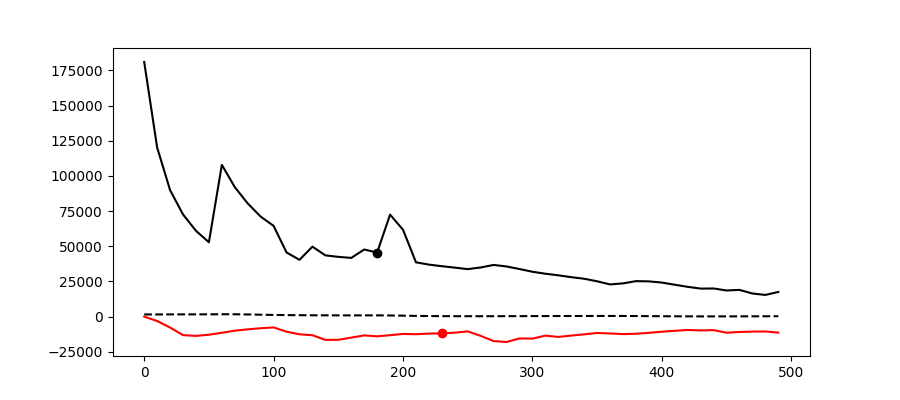

In [43]:
%matplotlib notebook
from nsfds2.utils.graphics import get_data, DataGenerator
import matplotlib.pyplot as plt
import numpy as _np

data = get_data('/home/cdesjouy/dev/apps/nsfds2/results/tmp.hdf5')

nt = data['nt'][...]
ns = data['ns'][...]
x = _np.arange(0, nt, ns)

var = DataGenerator(data, view='p')

maxs = []
mins = []
means = []
for _, v in var:
    maxs.append(v.max())
    mins.append(v.min())
    means.append(v.mean())

data.close()    

maxs = _np.array(maxs)
mins = _np.array(mins)
means = _np.array(means)

refmax = abs(maxs - maxs.mean()).argmin()*ns
refmin = abs(mins - mins.mean()).argmin()*ns

print(f'{mins[int(refmin/ns)-1]}, {maxs[int(refmax/ns)-1]}, {means.mean()}')

plt.figure(figsize=(9,4))
plt.plot(x, maxs, 'k')
plt.plot(x, means, 'k--')
plt.plot(x, mins, 'r')
plt.plot(refmin, mins[int(refmin/ns)], 'ro')
plt.plot(refmax, maxs[int(refmax/ns)], 'ko')
plt.show()

In [30]:
refmin/ns, refmax/ns

23.0

---


# Quiver tests

---

In [150]:
%matplotlib notebook
from nsfds2.utils.graphics import get_data, DataGenerator
import matplotlib.pyplot as plt
import numpy as _np

data = get_data('/home/cdesjouy/dev/apps/nsfds2/results/tmp.hdf5')
var = DataGenerator(data)
it = 5000
vx = var.get('vx', it)
vz = var.get('vz', it)
p = var.get('p', it)
x = data['x'][...]
z = data['z'][...]
data.close()

<IPython.core.display.Javascript object>


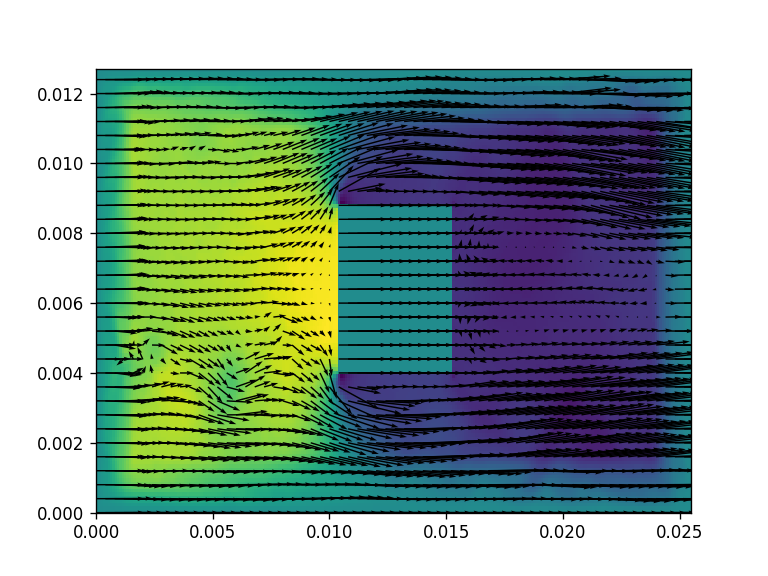

In [151]:
X, Z = np.meshgrid(x, z)

N = 2**2

fig, ax = plt.subplots()
ax.pcolorfast(x, z, p)
Q = ax.quiver(X[::N, ::N], Z[::N, ::N], vx[::N, ::N], vz[::N, ::N],  units='width', scale=4000)

<IPython.core.display.Javascript object>


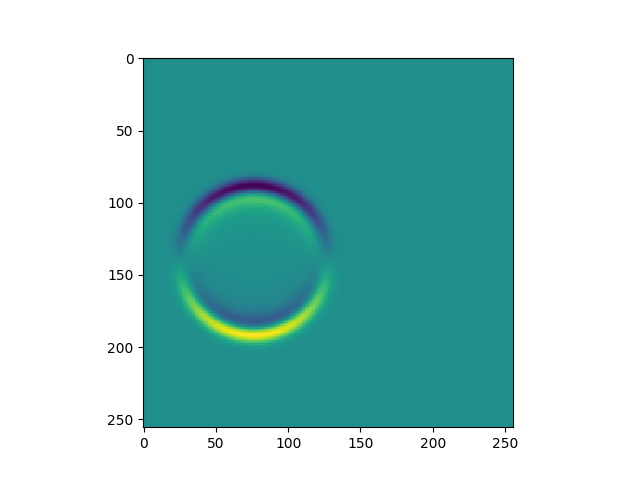

In [12]:
plt.figure()
plt.imshow(vz)
plt.show()

In [32]:
X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))

---

# Resample tests

---

In [317]:
from scipy.io import wavfile
import scipy.signal as sps

def resample(file, target_rate, N_target, write=False, force_mono=True):
    
    target_rate = int(target_rate)
    
    if not 1 < target_rate < 4.3e6:
        raise ValueError('Sampling rate must be 1 < rate < 4.3e6')
        
    path = os.path.dirname(file)
    filename = os.path.basename(file).split('.')
    rate, data = wavfile.read(file)
    dtype = data.dtype
    duration = data.shape[0]/rate
    N = int(target_rate*duration)
            
    if len(data.shape) == 2 and force_mono:   # stereo to mono
        data = (data[:, 0] + data[:, 1])/2
        
    print(f'Resampling {file} at {target_rate} kHz ({N} points)...')
    if len(data.shape) == 1:   # mono
        data_r = sps.resample(data, N).astype(dtype)
        
    if len(data.shape) == 2:   # stereo
        tmp_l = sps.resample(data[:, 0], N).astype(dtype)
        tmp_r = sps.resample(data[:, 1], N).astype(dtype)
        data_r = np.vstack([tmp_l, tmp_r]).T
    
    if write:
        print(f'Writing {N} samples at {target_rate} kHz rate...')
        wavfile.write('{}_r.{}'.format(*filename), rate=target_rate, data=data_r)
    
    return data_r/abs(data_r).max()

Resampling spam.wav at 16000 kHz (38744 points)...


<IPython.core.display.Javascript object>


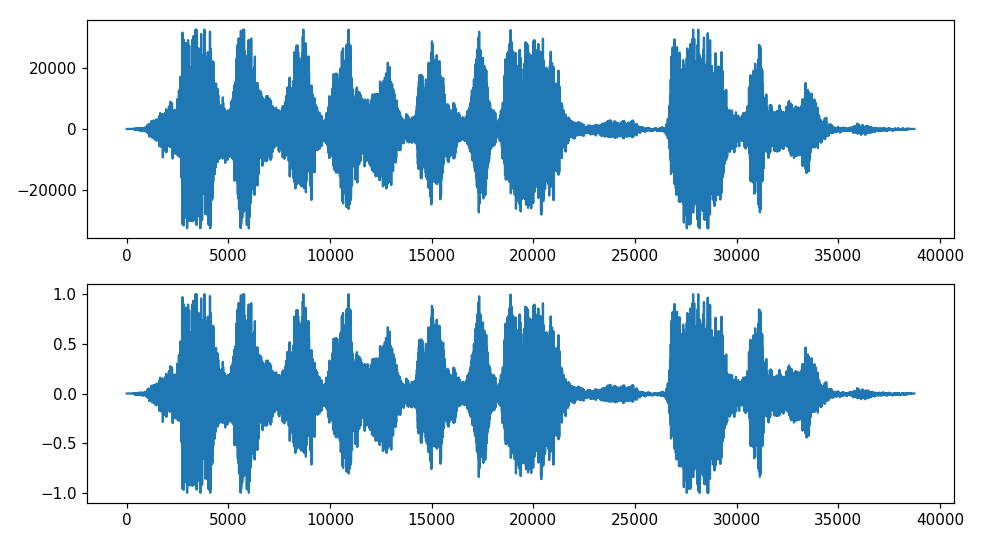

In [473]:
%matplotlib notebook


file = 'spam.wav'
dt = 0.5e-6
rate, data = wavfile.read(file)
data_r = resample(file, rate)

plt.figure(figsize=(9, 5))
plt.subplot(211)
plt.plot(data)
plt.subplot(212)
plt.plot(data_r)
plt.tight_layout()
plt.show()

---

# Compare signal and resampled signal

---

Resampling /home/cdesjouy/.nsfds2/spam.wav at 16000 kHz (6642 points)...
Writing 6642 samples at 16000 kHz rate...


<IPython.core.display.Javascript object>


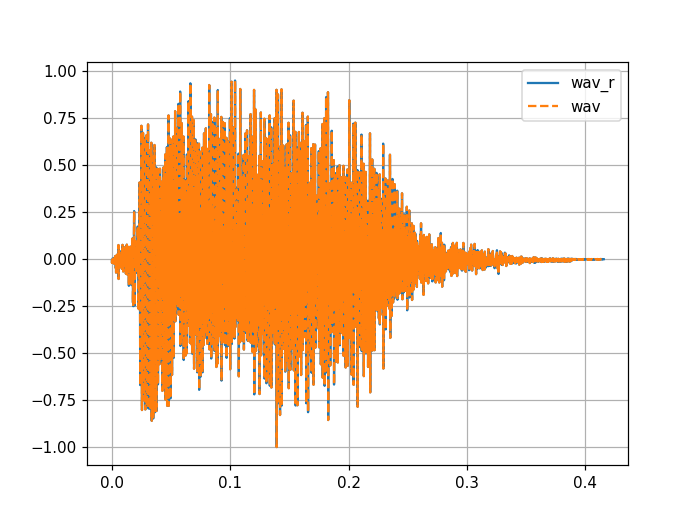

In [469]:
f = 16000

rate, wav = wavfile.read(wavename)
t = np.arange(0, wav.shape[0]/rate, 1/rate)
wav_r = resample(wavename, target_rate=f, pad=nt, write=True)
t_r = np.arange(0, wav_r.shape[0]/f, 1/f)

plt.figure()
plt.plot(t_r, wav_r, label='wav_r')
plt.plot(t, wav/abs(wav).max(),'--', label='wav')
plt.grid()
plt.legend()
plt.show()

---

# Compare wave and probes + listen wav

---

In [6]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from nsfds2.utils import DataExtractor
from nsfds2.utils.sounds import resample, normalize


wavename = '/home/cdesjouy/.nsfds2/spam3.wav'

rate, wav = wavfile.read(wavename)

with DataExtractor('~/dev/apps/nsfds2/results/tmp.hdf5') as data:
    probes = data.get_dataset('probes_value')
    p0 = data.get_attr('p0')
    dt = data.get_attr('dt')
    nt = data.get_attr('nt')

tprobes = np.arange(0, nt*dt, dt)
twav = np.arange(0, wav.shape[0]/rate, 1/rate)

probes = (probes[0] - p0)
probes = probes*abs(wav).max()/abs(probes).max()
probes = probes.astype(wav.dtype)

wav_r = resample(wavename, target_rate=1/dt, pad=nt)
wav_r = wav_r*abs(wav).max()/abs(wav_r).max()
wav_r = wav_r.astype(wav.dtype)

wavfile.write('probes.wav', rate=int(1/dt), data=normalize(probes))

Resampling /home/cdesjouy/.nsfds2/spam3.wav at 16000 kHz (38744 points)...
Set nt > 38744 to play the whole sound


<IPython.core.display.Javascript object>


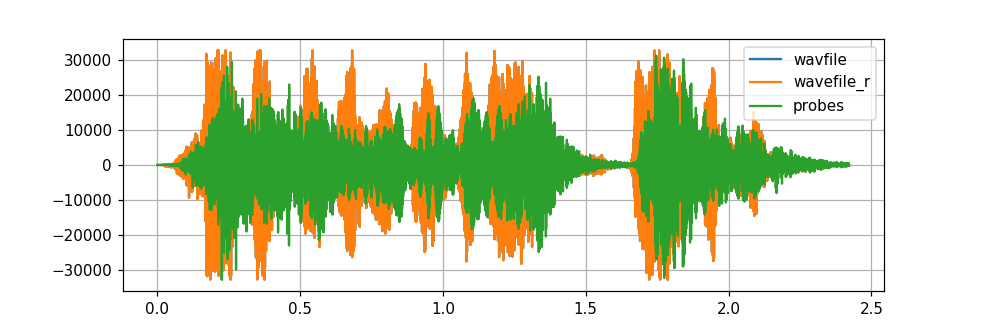

In [4]:
plt.figure(figsize=(9, 3))
plt.plot(twav, wav, label='wavfile')
plt.plot(tprobes, wav_r, label='wavefile_r')
plt.plot(tprobes, probes, label='probes')
plt.grid()

plt.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nsfds2.utils.sounds import probes_to_wave

a = probes_to_wave('~/dev/apps/nsfds2/results/tmp.hdf5')

In [ ]:
plt.figure()
plt.plot(p)
plt.show()

In [2]:
data = DataExtractor('~/dev/apps/nsfds2/results/tmp.hdf5')

In [5]:
'abd'.isalpha()

True

# Advices (FFT/DSP)

<IPython.core.display.Javascript object>


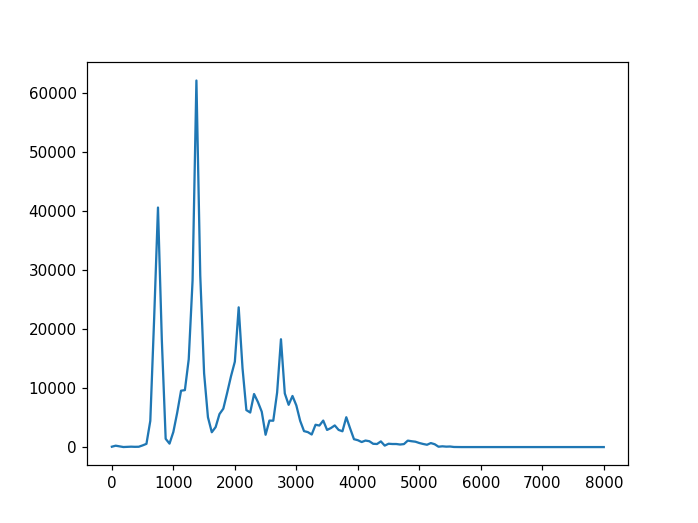

dx: 0.0425
62097.69140625


In [470]:
from scipy import signal

def advice(filename):
    rate, wav = wavfile.read(wavename)
    s = slice(0, int(wav.shape[0]/2))
    f, dsp = signal.welch(wav, rate)
    #f, dsp = signal.welch(wav[:,0], rate)
    
    plt.figure()
    plt.plot(f, dsp)
    print('dx:', 340/f[-1])
    print(dsp.max()-40)
    
    
wavename = '/home/cdesjouy/Documents/tmp/spam3.wav'
advice(wavename)

In [408]:
rate, wav = wavfile.read('/home/cdesjouy/Documents/tmp/spam3.wav')

<IPython.core.display.Javascript object>


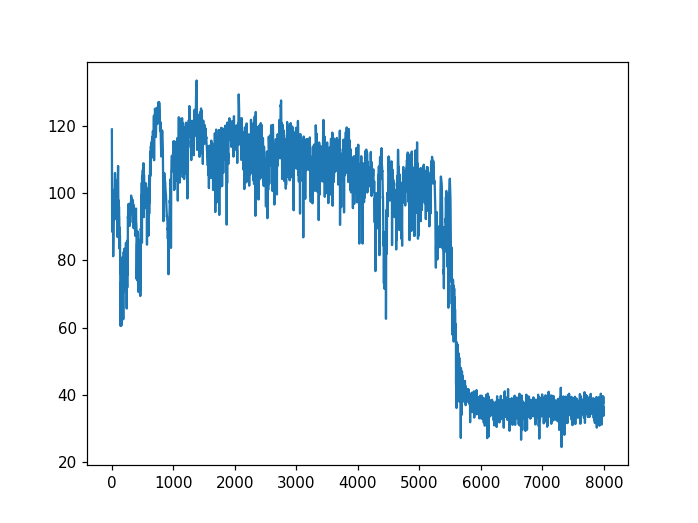

In [410]:
from scipy import fftpack
WAV = 20*np.log10(np.abs(fftpack.fft(wav)))
#WAV = 20*np.log10(np.abs(fftpack.fft(wav[:, 0])))
f = fftpack.fftfreq(wav.shape[0], 1/rate)
s = slice(0, int(wav.shape[0]/2))

plt.figure()
plt.plot(f[s], WAV[s])
plt.show()

In [4]:
import playsound

In [5]:
playsound.playsound('spam.wav')

In [3]:
import gi

In [248]:
np.random.seed(1234)

In [250]:
np.random.normal(size=100)

array([ 0.29120536,  0.5665337 ,  0.50359176,  0.28529568,  0.48428811,
        1.36348151, -0.78110528, -0.46801767,  1.22457436, -1.28110828,
        0.8754755 , -1.71071532, -0.4507651 ,  0.74916381, -0.20393287,
       -0.18217541,  0.680656  , -1.81849899,  0.04707164,  0.39484421,
       -0.24843205, -0.61770665, -0.682884  ,  0.4362576 , -1.70301277,
        0.3937106 , -0.479324  , -0.29901629,  0.69410329,  0.67862967,
        0.239556  ,  0.15122663,  0.81612723,  1.89353447,  0.63963276,
       -0.96202883, -2.08526564,  1.93024677, -1.73534887,  1.2103837 ,
        0.79743542, -0.37981078,  0.70256222, -0.85034627,  1.17681245,
       -0.5243361 ,  0.70090773,  0.98418807, -0.12172841,  2.36576863,
        0.49614293,  0.79659487, -0.47402089, -0.05669572,  1.35779726,
       -0.80483372, -2.12362025, -0.33350244, -0.88671935,  0.33419793,
        0.53678382, -0.74383037, -0.32020388, -0.91619886, -0.8596683 ,
        0.22598549,  0.62877583,  0.18649435,  0.95247835,  0.98

In [237]:
seed = "Non"

In [238]:
seed.isnumeric()

False

In [251]:
from scipy.signal import tukey

/home/cdesjouy/.virtualenvs/sci/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cdesjouy/.virtualenvs/sci/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/cdesjouy/.virtualenvs/sci/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<IPython.core.display.Javascript object>


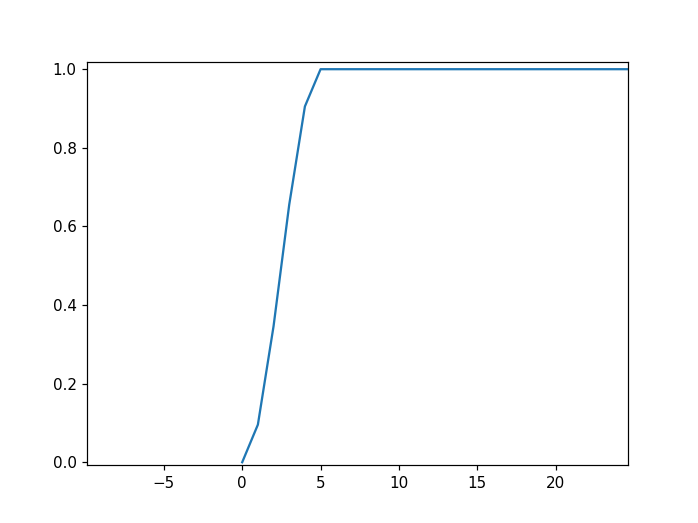

In [257]:
plt.figure()
plt.plot(tukey(1000, alpha=0.01))
plt.show()

In [258]:
1/1.4

0.7142857142857143